# TA Project LDA

In [1]:
# load libraries
import pandas as pd
import re

# load & process data
songs = pd.read_csv('hot100.csv').drop(columns='Unnamed: 0')
songs['lyrics'] = songs['lyrics'].str.lower() # make lowercase
songs['lyrics'] = songs['lyrics'].map(lambda x: re.sub('[,\.!?]', '', x)) # remove punctuation
songs.head()

,year,rank,song,artist,lyrics
0,2002,1,Foolish,Ashanti,murder inc ashanti see my days are cold w...
1,2002,2,U Don't Have To Call,Usher,yo after tonight don't leave your girl aroun...
2,2002,3,halfcrazy,Musiq,la la la la la la la la la la la la la la la...
3,2002,4,Hot In Herre,Nelly,it's hot in so hot in herre so hot in hot - ...
4,2002,5,Anything,Jaheim,yea ooh yea yea yea yea you can have anythi...


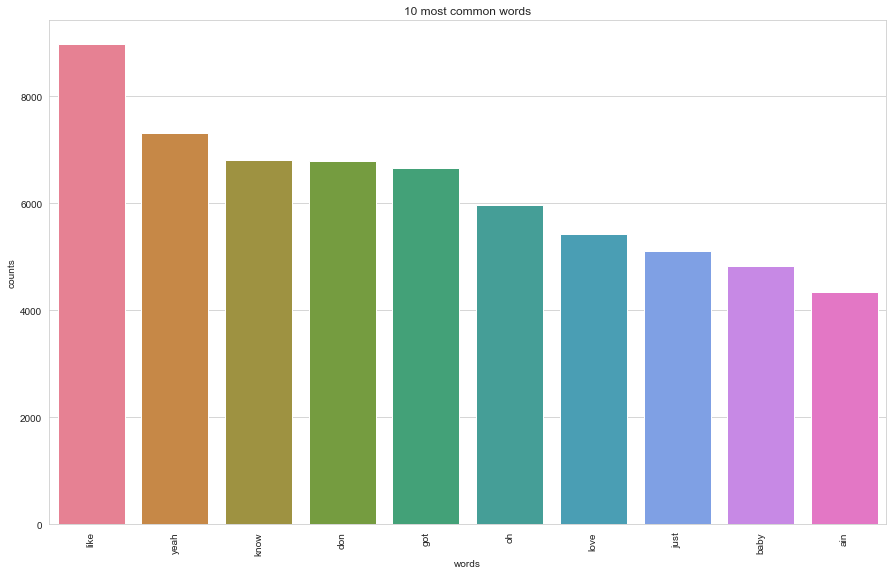

In [2]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(songs['lyrics'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# diff topics each year

In [3]:
def get_sim(x):
    temp = pd.DataFrame(x)
    temp['sum'] = sums
    return cosine_similarity(temp.T)[0,1]

In [179]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA # Load the LDA model from sk-learn
from sklearn.metrics.pairwise import cosine_similarity
        
# Tweak the two parameters below
number_topics = 5
number_words = 20

# save year as vector
years = songs['year'].unique()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# define dataframes
temp = pd.DataFrame(np.zeros((number_words,number_topics)))
topics = pd.DataFrame(np.zeros((0,number_topics)))
sims = pd.DataFrame(np.zeros((0,number_topics)))
tops = pd.DataFrame(np.zeros((0,number_topics)))

# run LDA for each year
for year in years:
    
    # run LDA
    lyrics = songs[songs['year']==year] # save period data
    count_data = count_vectorizer.fit_transform(lyrics['lyrics']) # fit and transform
    lda = LDA(n_components=number_topics, n_jobs=-1,random_state=1) # Create and fit the LDA model
    lda.fit(count_data)

    # save LDA
    temp['year'] = year
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        temp[topic_idx]= [words[i] for i in topic.argsort()[:-number_words - 1:-1]]
    
    topics = topics.append(temp).reset_index(drop=True)
    
    # get topic distributions
    sim = lda.transform(count_data)
    sim = lyrics.iloc[:,:-1].reset_index(drop=True).merge(pd.DataFrame(sim),how='left',left_index=True,right_index=True)

    sims = sims.append(sim).reset_index(drop=True)
    
    # sum probabilities to get average topics for year
    sums = sim.iloc[:,4:].apply(sum)
    sums = sums/sums.max()
    
    # score songs in comparison to average for most-that-year song
    sim['score'] = sim.iloc[:,4:].T.apply(get_sim)
    top = sim.sort_values(by='score',ascending=False).iloc[0,:]
    
    tops = tops.append(top).reset_index(drop=True)
    
topics

,0,1,2,3,4,year
0,la,uh,yo,bah,got,2002.0
1,love,don,like,know,don,2002.0
2,know,love,gots,like,baby,2002.0
3,baby,just,got,da,wanna,2002.0
4,just,girl,girls,woman,like,2002.0
...,...,...,...,...,...,...
250,chika,fuck,shit,just,nigga,2019.0
251,ain,nigga,need,bitch,type,2019.0
252,talk,cause,want,lot,know,2019.0
253,know,make,ass,gon,niggas,2019.0


# same topics each year

In [5]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA # Load the LDA model from sk-learn
from sklearn.metrics.pairwise import cosine_similarity
        
# Tweak the two parameters below
number_topics = 5
number_words = 20

# save year as vector
years = songs['year'].unique()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# define dataframes
topics = pd.DataFrame(np.zeros((number_words,number_topics)))

# run LDA
lyrics = songs.copy()# save period data
count_data = count_vectorizer.fit_transform(lyrics['lyrics']) # fit and transform
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=1) # Create and fit the LDA model
lda.fit(count_data)

# save LDA
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    topics[topic_idx] = [words[i] for i in topic.argsort()[:-number_words - 1:-1]]
    
# get topic distributions
dist = lda.transform(count_data)
dist = lyrics.iloc[:,:-1].reset_index(drop=True).merge(pd.DataFrame(dist),how='left',left_index=True,right_index=True)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
yeah like got don know nigga ain shit fuck bitch niggas money just ayy gon cause em man tell say

Topic #1:
oh love baby know don girl just yeah like wanna ooh let got want cause ll ain way make right

Topic #2:
hol got life boy bitch dem watch ayy like di hitta wasted pretty just fo know yeah bottoms ain ya

Topic #3:
like hey let work rock got wanna walk em bitch wit whoa cause just swagger ain boy say ride know

Topic #4:
like make ain got ass hot just bitch nigga whip let ma girl uh shit don low know gotta hit


In [236]:
def get_sim(x, avg):
    temp = pd.DataFrame(x)
    temp['sum'] = avg
    return cosine_similarity(temp.T)[0,1]

tops = pd.DataFrame(np.zeros((0,number_topics)))
sums = pd.DataFrame(np.zeros((number_topics,0)))

for year in years:
    
    sim = dist[dist['year']==year]
    
    # sum probabilities to get average topics for year
    avg = sim.iloc[:,4:].apply(np.mean)
    sums[year] = avg # save for plot
    avg = pd.DataFrame(avg/avg.max()) # normalize
    
    # score songs in comparison to average for most-that-year song
    sim['score'] = sim.iloc[:,4:].T.apply(lambda x: get_sim(x, avg))
    top = sim.sort_values(by='score',ascending=False).iloc[0,:]
    
    tops = tops.append(top).reset_index(drop=True)
    
tops

C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,0,1,2,3,4,artist,rank,score,song,year
0,0.131153,0.758336,0.000840,0.000843,0.108828,Ja Rule,7.0,0.986787,Always On Time,2002.0
1,0.137600,0.682920,0.000495,0.000501,0.178484,Chingy,6.0,0.978613,Right Thurr,2003.0
2,0.230993,0.542588,0.000655,0.000660,0.225104,Kanye West,23.0,0.975463,All Falls Down,2004.0
3,0.346481,0.565877,0.000694,0.000699,0.086249,Webbie,33.0,0.986367,Give Me That,2005.0
4,0.280250,0.627760,0.000900,0.032127,0.058963,Jay-Z,97.0,0.983047,Lost One,2007.0
5,0.235758,0.759395,0.001612,0.001620,0.001615,Marvin Sapp,36.0,0.983831,Never Would Have Made It,2008.0
6,0.094990,0.700050,0.000681,0.203593,0.000687,Trey Songz,77.0,0.981674,I Invented Sex,2009.0
7,0.158014,0.575229,0.000494,0.085386,0.180878,Ludacris,39.0,0.979366,Sex Room,2010.0
8,0.232029,0.620300,0.000650,0.146366,0.000655,J. Cole,85.0,0.987432,Work Out,2011.0
9,0.320436,0.496999,0.000690,0.048006,0.133868,J. Cole,25.0,0.988440,Can't Get Enough,2012.0


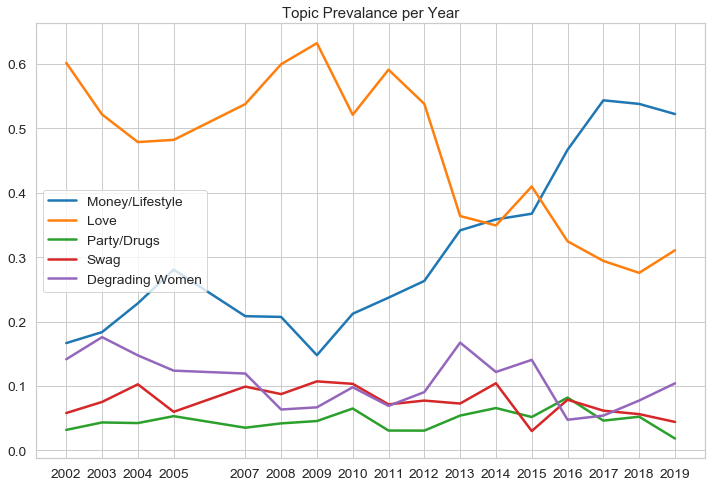

In [267]:
cols = {0:'Money/Lifestyle',1:'Love',2:'Party/Drugs',3:'Swag',4:'Degrading Women'}
sums.rename(columns=cols,inplace=True)
sums.plot(figsize=(12,8), title='Topic Prevalance per Year',xticks=sums.index)

In [263]:
tops[['year','artist','song','score']]

,year,artist,song,score
0,2002.0,Ja Rule,Always On Time,0.986787
1,2003.0,Chingy,Right Thurr,0.978613
2,2004.0,Kanye West,All Falls Down,0.975463
3,2005.0,Webbie,Give Me That,0.986367
4,2007.0,Jay-Z,Lost One,0.983047
5,2008.0,Marvin Sapp,Never Would Have Made It,0.983831
6,2009.0,Trey Songz,I Invented Sex,0.981674
7,2010.0,Ludacris,Sex Room,0.979366
8,2011.0,J. Cole,Work Out,0.987432
9,2012.0,J. Cole,Can't Get Enough,0.988440


In [264]:
sums

,Money/Lifestyle,Love,Party/Drugs,Swag,Degrading Women
2002,0.166658,0.601928,0.031818,0.058027,0.141569
2003,0.183740,0.521739,0.043391,0.075250,0.175879
2004,0.228462,0.478873,0.042434,0.102640,0.147591
2005,0.280806,0.482289,0.053166,0.059890,0.123848
2007,0.208429,0.537910,0.035200,0.099085,0.119376
2008,0.207328,0.599790,0.041959,0.087415,0.063508
2009,0.147862,0.632475,0.045579,0.107206,0.066878
2010,0.212220,0.521278,0.065036,0.103370,0.098097
2011,0.237233,0.591326,0.030803,0.071491,0.069147
2012,0.263206,0.538194,0.030711,0.077349,0.090539
